In [1]:
# parser = argparse.ArgumentParser(description="Choose RNN module: LSTM or GRU")
# parser.add_argument("--rnn_module", type=str, default="LSTM", help="Choose RNN module: LSTM or GRU")
# args = parser.parse_args()
#rnn = "LSTM"
rnn = "GRU"



In [2]:
import os
current_working_directory = os.getcwd()
print(current_working_directory)

import matplotlib.pyplot as plt
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import scipy.io as sio

from tqdm import trange, tqdm
import argparse

# Import the quadruped model components from your second file
from mlp_quadruped_rnn import MLP, MLPQuadrupedProjectionFilter, CustomGRULayer, GRU_Hidden_State, CustomLSTMLayer, LSTM_Hidden_State
from stance_leg_controller import ForceStanceLegController

from scipy.spatial.transform import Rotation as R

/home/alinjar/simple_training_warm_start/Quadruped_qp


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:
class ForceDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, inp, desired_speed, desired_twisting_speed):
        # input
        self.inp = inp
        self.desired_speed = desired_speed
        self.desired_twisting_speed = desired_twisting_speed

    def __len__(self):
        return len(self.inp)    
        
    def __getitem__(self, idx):
        # Input
        inp = self.inp[idx]
        desired_speed = self.desired_speed[idx]
        desired_twisting_speed = self.desired_twisting_speed
        return torch.tensor(inp).float(), torch.tensor(desired_speed).float(), torch.tensor(desired_twisting_speed).float()    


def sample_uniform_variables(key, var_min, var_max, dataset_size, nvar):
    rng = np.random.default_rng(seed=key)
    xi_samples = rng.uniform(
        low=var_min,
        high=var_max,
        size=(dataset_size, nvar)
    )
    return xi_samples, rng

In [5]:
# Parameters for Quadruped Model
num_batch = 1000
timestep = 0.05  
horizon = 10     # prediction horizon steps
num_legs = 4
friction_coeff = 0.2
body_mass = 50.0  # kg

body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

# Desired motion parameters
desired_speed = (0.0, 0.0)        # m/s
desired_twisting_speed = 0.5  # rad/s
desired_body_height = 0.5     # m

# Force limits
F_max = 100.0  # Maximum force magnitude for sampling

# Problem dimensions for quadruped force control


##Parameters for MLP model
# Default states
BaseRollPitchYaw = (0.0, 0.0, 0.0)
AngularVelocityBodyFrame = (0.0, 0.0, 0.0)
ComVelocityBodyFrame = (0.0, 0.0, 0.0)
FootContacts = (True, True, True, True)
slope_estimate = (0.0, 0.0, 0.0)
RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [6]:
# Parameters for Quadruped Model
num_batch = 1
timestep = 0.05  # 50 Hz control frequency
horizon = 10     # prediction horizon steps
num_legs = 4
friction_coeff = 0.2
body_mass = 50.0  # kg

body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

# Desired motion parameters
# desired_speed_x_tensor, rng = sample_uniform_variable(42, -0.5, 0.5, 1, 1)
# desired_speed_x = desired_speed_x_tensor.squeeze().item()
# print("desired_speed_x", desired_speed_x)
desired_body_height = 0.5     # m

##Parameters for MLP model
# Default states
BaseRollPitchYaw = (0.0, 0.0, 0.0)
AngularVelocityBodyFrame = (0.0, 0.0, 0.0)
ComVelocityBodyFrame = (0.0, 0.0, 0.0)
FootContacts = (True, True, True, True)
slope_estimate = (0.0, 0.0, 0.0)
RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

roll, pitch, yaw = BaseRollPitchYaw

# Create rotation object from Euler angles (in radians)
rot = R.from_euler('xyz', [roll, pitch, yaw])

# Convert to rotation matrix
rotation_matrix = rot.as_matrix()  # Shape (3, 3)

# Flatten into a 9-element tuple (row-major order)
RotationBodyWrtWorld = tuple(rotation_matrix.flatten())
#self.RotationBodyWrtWorld = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [7]:
"""Setup foot positions and default states for quadruped"""
# Foot positions in body frame
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

FootPositionsInBodyFrame = torch.tensor([
    [ foot_x,  foot_y, foot_z],
    [-foot_x,  foot_y, foot_z],
    [ foot_x, -foot_y, foot_z],
    [-foot_x, -foot_y, foot_z]])

# Define QP matrices for quadruped control (simplified example)
# In practice, these would come from your quadruped dynamics model




# Maximum Iterations
maxiter_projection = 20

nvar = 3*num_legs*horizon

num_total_constraints = 2*nvar

In [8]:
desired_speed_batched, rng_desired_speed_batched = sample_uniform_variables(41, var_min= -0.2, var_max = 0.2, dataset_size=num_batch, nvar=2)
desired_twisting_speed_batched,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      42, var_min= -0.2, var_max = 0.2, dataset_size=num_batch, 
                                                                      nvar=1)

desired_speed_batched_val, rng_desired_speed_batched = sample_uniform_variables(40, var_min= -0.1, var_max = 0.1, dataset_size=num_batch, nvar=2)
desired_twisting_speed_batched_val,  rng_desired_twisting_speed_batched = sample_uniform_variables(
                                                                      39, var_min= -0.1, var_max = 0.1, dataset_size=num_batch,
                                                                      nvar=1)

print("desired_speed_batched.shape", desired_speed_batched.shape)
print("desired_twisting_speed_batched.shape", desired_twisting_speed_batched.shape)

inp = np.hstack((desired_speed_batched, desired_twisting_speed_batched))

inp_val = np.hstack(( desired_speed_batched_val, desired_twisting_speed_batched_val))

# Using PyTorch Dataloader
train_dataset = ForceDataset(inp, desired_speed_batched, desired_twisting_speed_batched)
val_dataset = ForceDataset(inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val)

train_loader = DataLoader(train_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=num_batch, shuffle=True, num_workers=0, drop_last=True)

if rnn == "GRU":
    print("Training with GRU")
    #GRU handling
    rnn = "GRU"
    gru_input_size = 3*num_total_constraints+3*nvar
    # print(gru_input_size)
    gru_hidden_size = 512
    # gru_output_size = (2*nvar)**2+2*nvar
    gru_output_size = num_total_constraints+nvar
    # gru_context_size = mlp_planner_inp_dim

    gru_context = CustomGRULayer(gru_input_size, gru_hidden_size, gru_output_size)

    rnn_context = gru_context


    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = gru_hidden_size

    gru_init  =  GRU_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)
    
    rnn_init = gru_init
    ##
elif rnn == "LSTM":
    print("Training with LSTM")
    #LSTM handling
    rnn = "LSTM"
    lstm_input_size = 3*num_total_constraints+3*nvar
    # print(lstm_input_size)
    lstm_hidden_size = 512
    # lstm_output_size = (2*nvar)**2+2*nvar
    lstm_output_size = num_total_constraints+nvar
    # lstm_context_size = mlp_planner_inp_dim

    lstm_context = CustomLSTMLayer(lstm_input_size, lstm_hidden_size, lstm_output_size)

    rnn_context = lstm_context

    input_hidden_state_init = np.shape(inp)[1]
    mid_hidden_state_init = 512
    out_hidden_state_init = lstm_hidden_size

    lstm_init = LSTM_Hidden_State(input_hidden_state_init, mid_hidden_state_init, out_hidden_state_init)

    rnn_init = lstm_init

    ##

desired_speed_batched.shape (1, 2)
desired_twisting_speed_batched.shape (1, 1)
Training with GRU


In [9]:
# MLP setup
enc_inp_dim = np.shape(inp)[1] 
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 2*nvar + num_total_constraints  # xi_samples, lambda_samples, slack_variables

mlp = MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)

# Create the quadruped model
model = MLPQuadrupedProjectionFilter(
    mlp=mlp,
    rnn_context=rnn_context, 
    rnn_init=rnn_init, 
    num_batch=num_batch,
    maxiter_projection=maxiter_projection,
    BaseRollPitchYaw=BaseRollPitchYaw,
    AngularVelocityBodyFrame=AngularVelocityBodyFrame,
    ComVelocityBodyFrame=ComVelocityBodyFrame,
    FootPositionsInBodyFrame=FootPositionsInBodyFrame,
    FootContacts=FootContacts,
    slope_estimate=slope_estimate,
    RotationBodyWrtWorld=RotationBodyWrtWorld, 
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    rnn=rnn).to(device)

print(f"Model type: {type(model)}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


Model type: <class 'mlp_quadruped_rnn.MLPQuadrupedProjectionFilter'>
Number of parameters: 4869192


In [10]:
# Training
epochs = 1000
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=6e-5)

losses = []
last_loss = torch.inf
avg_train_loss, avg_primal_loss, avg_fixed_point_loss, avg_projection_loss = [], [], [], []
avg_val_loss = []

for epoch in range(epochs):
    
    # Train Loop
    model.train()
    losses_train, primal_losses, fixed_point_losses, projection_losses = [], [], [], []
    
    for (inp, desired_speed_batched, desired_twisting_speed_batched) in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        
        # Input and Output 
        inp = inp.to(device)
        desired_speed_batched = desired_speed_batched.to(device)
        desired_twisting_speed_batched = desired_twisting_speed_batched.to(device)
        
        # Forward pass through quadruped model
        xi_projected, avg_res_fixed_point, avg_res_primal, res_primal_history, res_fixed_point_history = model(inp, desired_speed_batched, 
                                                                                                               desired_twisting_speed_batched, rnn)
        
        
        # Compute loss
        primal_loss, fixed_point_loss, loss = model.mlp_loss(
            avg_res_primal, avg_res_fixed_point)

        optimizer.zero_grad()
        loss.backward()
        
        # Optional gradient clipping
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        primal_losses.append(primal_loss.detach().cpu().numpy())
        fixed_point_losses.append(fixed_point_loss.detach().cpu().numpy())
        #projection_losses.append(projection_loss.detach().cpu().numpy())
        
    # Validation every 2 epochs
    if epoch % 2 == 0:
        model.eval()
        val_losses = []

        with torch.no_grad():
            for (inp_val, desired_speed_batched_val, desired_twisting_speed_batched_val) in tqdm(val_loader, desc="Validation"):
                inp_val = inp_val.to(device)
                desired_speed_batched_val = desired_speed_batched_val.to(device)
                desired_twisting_speed_batched_val = desired_twisting_speed_batched_val.to(device)

                xi_projected, avg_res_fixed_point, avg_res_primal, res_primal_history, res_fixed_point_history = model(inp_val, desired_speed_batched_val, 
                                                                                                                       desired_twisting_speed_batched_val,
                                                                                                                       rnn)
                
                _, _, val_loss = model.mlp_loss(
                    avg_res_primal, avg_res_fixed_point
                )

                val_losses.append(val_loss.detach().cpu().numpy())

    # Print progress every 2 epochs
    if epoch % 2 == 0:    
        print(f"Epoch: {epoch + 1}")       
        if len(val_losses) > 0:
            print(f"Validation Loss: {np.average(val_losses):.4f}")

    # Save best model
    os.makedirs("./training_weights", exist_ok=True)
    if loss <= last_loss:
        torch.save(model.state_dict(), f"./training_weights/mlp_learned_quadruped_{rnn}.pth")
        last_loss = loss

    # Store metrics
    avg_train_loss.append(np.average(losses_train))
    avg_primal_loss.append(np.average(primal_losses))
    avg_projection_loss.append(np.average(projection_losses))
    avg_fixed_point_loss.append(np.average(fixed_point_losses))
    
    if len(val_losses) > 0:
        avg_val_loss.append(np.average(val_losses))
    else:
        avg_val_loss.append(avg_val_loss[-1] if avg_val_loss else 0.0)

print("Training completed!")



Validation: 100%|██████████| 1/1 [00:00<00:00, 28.52it/s]
/home/alinjar/manipulator_torch_env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/alinjar/manipulator_torch_env/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch: 1
Validation Loss: 65.8038


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


Epoch: 3
Validation Loss: 42.2345


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]


Epoch: 5
Validation Loss: 35.8979


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]


Epoch: 7
Validation Loss: 37.6110


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.18it/s]


Epoch: 9
Validation Loss: 35.1244


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.70it/s]


Epoch: 11
Validation Loss: 36.3254


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]


Epoch: 13
Validation Loss: 34.7716


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Epoch: 15
Validation Loss: 34.8319


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]


Epoch: 17
Validation Loss: 33.0164


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s]


Epoch: 19
Validation Loss: 32.5501


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.26it/s]


Epoch: 21
Validation Loss: 31.5564


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.30it/s]


Epoch: 23
Validation Loss: 32.1366


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.59it/s]


Epoch: 25
Validation Loss: 30.6002


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s]


Epoch: 27
Validation Loss: 30.2765


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.95it/s]


Epoch: 29
Validation Loss: 30.3767


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.13it/s]


Epoch: 31
Validation Loss: 30.0682


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s]


Epoch: 33
Validation Loss: 29.9183


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.17it/s]


Epoch: 35
Validation Loss: 28.2889


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.63it/s]


Epoch: 37
Validation Loss: 27.9858


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.19it/s]


Epoch: 39
Validation Loss: 28.1282


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.83it/s]


Epoch: 41
Validation Loss: 27.3582


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.04it/s]


Epoch: 43
Validation Loss: 26.2736


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.65it/s]


Epoch: 45
Validation Loss: 25.8453


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.69it/s]


Epoch: 47
Validation Loss: 26.1665


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]


Epoch: 49
Validation Loss: 27.8438


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.22it/s]


Epoch: 51
Validation Loss: 25.8629


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.53it/s]


Epoch: 53
Validation Loss: 25.4349


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.34it/s]


Epoch: 55
Validation Loss: 25.1576


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]


Epoch: 57
Validation Loss: 29.1246


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s]


Epoch: 59
Validation Loss: 30.4370


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.98it/s]


Epoch: 61
Validation Loss: 29.3673


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


Epoch: 63
Validation Loss: 30.8837


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.55it/s]


Epoch: 65
Validation Loss: 28.6355


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


Epoch: 67
Validation Loss: 29.0470


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


Epoch: 69
Validation Loss: 27.0753


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.95it/s]


Epoch: 71
Validation Loss: 27.2584


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.51it/s]


Epoch: 73
Validation Loss: 26.4474


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


Epoch: 75
Validation Loss: 27.8501


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


Epoch: 77
Validation Loss: 27.7759


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


Epoch: 79
Validation Loss: 27.2508


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.73it/s]


Epoch: 81
Validation Loss: 27.5377


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.13it/s]


Epoch: 83
Validation Loss: 26.7129


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.63it/s]


Epoch: 85
Validation Loss: 25.5023


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


Epoch: 87
Validation Loss: 24.9352


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.13it/s]


Epoch: 89
Validation Loss: 25.1083


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.89it/s]


Epoch: 91
Validation Loss: 23.6856


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.76it/s]


Epoch: 93
Validation Loss: 24.9715


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.10it/s]


Epoch: 95
Validation Loss: 24.6794


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.10it/s]


Epoch: 97
Validation Loss: 24.5543


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.34it/s]


Epoch: 99
Validation Loss: 24.3226


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


Epoch: 101
Validation Loss: 22.9258


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


Epoch: 103
Validation Loss: 22.5813


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]


Epoch: 105
Validation Loss: 22.7318


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]


Epoch: 107
Validation Loss: 22.1695


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]


Epoch: 109
Validation Loss: 22.6605


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]


Epoch: 111
Validation Loss: 22.0856


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


Epoch: 113
Validation Loss: 22.4427


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.79it/s]


Epoch: 115
Validation Loss: 21.8011


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.61it/s]


Epoch: 117
Validation Loss: 21.3015


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.44it/s]


Epoch: 119
Validation Loss: 21.6516


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.85it/s]


Epoch: 121
Validation Loss: 21.0043


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]


Epoch: 123
Validation Loss: 21.0660


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]


Epoch: 125
Validation Loss: 20.7310


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.03it/s]


Epoch: 127
Validation Loss: 20.8756


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


Epoch: 129
Validation Loss: 20.9736


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.30it/s]


Epoch: 131
Validation Loss: 20.1568


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.68it/s]


Epoch: 133
Validation Loss: 20.6577


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.97it/s]


Epoch: 135
Validation Loss: 20.6759


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


Epoch: 137
Validation Loss: 20.5055


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.62it/s]


Epoch: 139
Validation Loss: 21.3335


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


Epoch: 141
Validation Loss: 20.2563


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]


Epoch: 143
Validation Loss: 20.1576


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.35it/s]


Epoch: 145
Validation Loss: 20.5176


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.86it/s]


Epoch: 147
Validation Loss: 20.3595


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


Epoch: 149
Validation Loss: 20.3619


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


Epoch: 151
Validation Loss: 20.5565


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.85it/s]


Epoch: 153
Validation Loss: 20.6660


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.33it/s]


Epoch: 155
Validation Loss: 19.8033


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.55it/s]


Epoch: 157
Validation Loss: 19.8113


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.34it/s]


Epoch: 159
Validation Loss: 19.9516


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s]


Epoch: 161
Validation Loss: 20.6248


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.63it/s]


Epoch: 163
Validation Loss: 20.4834


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.06it/s]


Epoch: 165
Validation Loss: 20.3285


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.49it/s]


Epoch: 167
Validation Loss: 20.1848


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.16it/s]


Epoch: 169
Validation Loss: 20.2127


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]


Epoch: 171
Validation Loss: 19.9618


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.14it/s]


Epoch: 173
Validation Loss: 19.4410


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


Epoch: 175
Validation Loss: 19.3137


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


Epoch: 177
Validation Loss: 20.0036


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.21it/s]


Epoch: 179
Validation Loss: 19.4732


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.54it/s]


Epoch: 181
Validation Loss: 19.3237


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.63it/s]


Epoch: 183
Validation Loss: 20.1254


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.91it/s]


Epoch: 185
Validation Loss: 19.6167


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]


Epoch: 187
Validation Loss: 19.2199


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]


Epoch: 189
Validation Loss: 18.7201


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.63it/s]


Epoch: 191
Validation Loss: 19.6295


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.22it/s]


Epoch: 193
Validation Loss: 20.2482


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.49it/s]


Epoch: 195
Validation Loss: 19.8584


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.20it/s]


Epoch: 197
Validation Loss: 19.0343


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.66it/s]


Epoch: 199
Validation Loss: 18.4948


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]


Epoch: 201
Validation Loss: 19.0640


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


Epoch: 203
Validation Loss: 18.8996


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]


Epoch: 205
Validation Loss: 18.6443


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


Epoch: 207
Validation Loss: 18.3713


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.07it/s]


Epoch: 209
Validation Loss: 18.0621


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


Epoch: 211
Validation Loss: 17.7131


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.61it/s]


Epoch: 213
Validation Loss: 18.0023


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.25it/s]


Epoch: 215
Validation Loss: 17.3366


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.73it/s]


Epoch: 217
Validation Loss: 17.6580


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


Epoch: 219
Validation Loss: 17.5425


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.77it/s]


Epoch: 221
Validation Loss: 18.0331


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.85it/s]


Epoch: 223
Validation Loss: 17.5963


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.92it/s]


Epoch: 225
Validation Loss: 17.3080


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s]


Epoch: 227
Validation Loss: 17.3183


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.34it/s]


Epoch: 229
Validation Loss: 17.7305


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.58it/s]


Epoch: 231
Validation Loss: 17.3637


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.57it/s]


Epoch: 233
Validation Loss: 17.2788


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.52it/s]


Epoch: 235
Validation Loss: 17.5198


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.70it/s]


Epoch: 237
Validation Loss: 17.0445


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.65it/s]


Epoch: 239
Validation Loss: 17.2337


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


Epoch: 241
Validation Loss: 16.8023


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.41it/s]


Epoch: 243
Validation Loss: 17.0323


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.65it/s]


Epoch: 245
Validation Loss: 17.6170


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s]


Epoch: 247
Validation Loss: 17.3556


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.88it/s]


Epoch: 249
Validation Loss: 16.4645


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.64it/s]


Epoch: 251
Validation Loss: 16.1937


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.92it/s]


Epoch: 253
Validation Loss: 16.2133


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]


Epoch: 255
Validation Loss: 16.1526


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


Epoch: 257
Validation Loss: 16.0526


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.48it/s]


Epoch: 259
Validation Loss: 15.8735


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.50it/s]


Epoch: 261
Validation Loss: 16.2061


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]


Epoch: 263
Validation Loss: 15.5937


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


Epoch: 265
Validation Loss: 16.4371


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.56it/s]


Epoch: 267
Validation Loss: 15.5014


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.21it/s]


Epoch: 269
Validation Loss: 15.6573


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.77it/s]


Epoch: 271
Validation Loss: 15.8205


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.60it/s]


Epoch: 273
Validation Loss: 15.5062


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


Epoch: 275
Validation Loss: 15.0955


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


Epoch: 277
Validation Loss: 15.2553


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.12it/s]


Epoch: 279
Validation Loss: 15.6951


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.40it/s]


Epoch: 281
Validation Loss: 15.1048


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.18it/s]


Epoch: 283
Validation Loss: 14.9695


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.51it/s]


Epoch: 285
Validation Loss: 14.5098


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s]


Epoch: 287
Validation Loss: 14.7839


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.21it/s]


Epoch: 289
Validation Loss: 14.2756


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.86it/s]


Epoch: 291
Validation Loss: 14.4581


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.89it/s]


Epoch: 293
Validation Loss: 14.3191


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]


Epoch: 295
Validation Loss: 14.0317


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


Epoch: 297
Validation Loss: 14.3086


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.15it/s]


Epoch: 299
Validation Loss: 13.9565


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.23it/s]


Epoch: 301
Validation Loss: 13.7515


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.58it/s]


Epoch: 303
Validation Loss: 13.5426


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.60it/s]


Epoch: 305
Validation Loss: 13.9101


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.21it/s]


Epoch: 307
Validation Loss: 13.7836


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]


Epoch: 309
Validation Loss: 13.7728


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.23it/s]


Epoch: 311
Validation Loss: 13.6022


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.59it/s]


Epoch: 313
Validation Loss: 14.0393


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.33it/s]


Epoch: 315
Validation Loss: 13.2045


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


Epoch: 317
Validation Loss: 13.0870


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.14it/s]


Epoch: 319
Validation Loss: 12.9538


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.69it/s]


Epoch: 321
Validation Loss: 12.8885


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.60it/s]


Epoch: 323
Validation Loss: 12.9298


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.98it/s]


Epoch: 325
Validation Loss: 13.4789


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.37it/s]


Epoch: 327
Validation Loss: 12.9943


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.28it/s]


Epoch: 329
Validation Loss: 12.7547


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


Epoch: 331
Validation Loss: 12.3113


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.65it/s]


Epoch: 333
Validation Loss: 12.8049


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.46it/s]


Epoch: 335
Validation Loss: 12.2614


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.12it/s]


Epoch: 337
Validation Loss: 12.4303


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.03it/s]


Epoch: 339
Validation Loss: 12.1690


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.54it/s]


Epoch: 341
Validation Loss: 12.0561


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.09it/s]


Epoch: 343
Validation Loss: 12.1620


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


Epoch: 345
Validation Loss: 11.7841


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.34it/s]


Epoch: 347
Validation Loss: 11.6654


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.64it/s]


Epoch: 349
Validation Loss: 12.0378


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.68it/s]


Epoch: 351
Validation Loss: 11.5943


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.37it/s]


Epoch: 353
Validation Loss: 11.7065


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.14it/s]


Epoch: 355
Validation Loss: 11.5891


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.30it/s]


Epoch: 357
Validation Loss: 11.7115


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.12it/s]


Epoch: 359
Validation Loss: 11.3200


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.97it/s]


Epoch: 361
Validation Loss: 11.0342


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.90it/s]


Epoch: 363
Validation Loss: 10.6991


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.62it/s]


Epoch: 365
Validation Loss: 10.9968


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.86it/s]


Epoch: 367
Validation Loss: 10.8013


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.79it/s]


Epoch: 369
Validation Loss: 10.9829


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.76it/s]


Epoch: 371
Validation Loss: 10.3994


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.59it/s]


Epoch: 373
Validation Loss: 10.1418


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


Epoch: 375
Validation Loss: 9.5930


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.31it/s]


Epoch: 377
Validation Loss: 10.4197


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.69it/s]


Epoch: 379
Validation Loss: 9.9860


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.96it/s]


Epoch: 381
Validation Loss: 9.6512


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.91it/s]


Epoch: 383
Validation Loss: 9.6495


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s]


Epoch: 385
Validation Loss: 9.3257


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.78it/s]


Epoch: 387
Validation Loss: 9.2040


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.81it/s]


Epoch: 389
Validation Loss: 9.1093


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.71it/s]


Epoch: 391
Validation Loss: 8.8437


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.21it/s]


Epoch: 393
Validation Loss: 8.8781


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.70it/s]


Epoch: 395
Validation Loss: 8.6502


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.73it/s]


Epoch: 397
Validation Loss: 8.8766


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.76it/s]


Epoch: 399
Validation Loss: 8.8103


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.61it/s]


Epoch: 401
Validation Loss: 8.4772


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


Epoch: 403
Validation Loss: 8.6910


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s]


Epoch: 405
Validation Loss: 8.0840


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.08it/s]


Epoch: 407
Validation Loss: 7.9193


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.30it/s]


Epoch: 409
Validation Loss: 8.3350


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.56it/s]


Epoch: 411
Validation Loss: 7.6043


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.05it/s]


Epoch: 413
Validation Loss: 7.8809


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.25it/s]


Epoch: 415
Validation Loss: 7.7753


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.53it/s]


Epoch: 417
Validation Loss: 7.3707


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.86it/s]


Epoch: 419
Validation Loss: 7.5312


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.71it/s]


Epoch: 421
Validation Loss: 7.5228


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Epoch: 423
Validation Loss: 7.2345


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.89it/s]


Epoch: 425
Validation Loss: 7.2730


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.08it/s]


Epoch: 427
Validation Loss: 7.0697


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Epoch: 429
Validation Loss: 6.7422


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.06it/s]


Epoch: 431
Validation Loss: 6.9507


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.97it/s]


Epoch: 433
Validation Loss: 6.5522


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.64it/s]


Epoch: 435
Validation Loss: 6.4782


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.50it/s]


Epoch: 437
Validation Loss: 6.3547


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.23it/s]


Epoch: 439
Validation Loss: 6.5152


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


Epoch: 441
Validation Loss: 6.2201


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.51it/s]


Epoch: 443
Validation Loss: 6.1013


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.05it/s]


Epoch: 445
Validation Loss: 6.0747


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.54it/s]


Epoch: 447
Validation Loss: 5.7539


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.47it/s]


Epoch: 449
Validation Loss: 5.3781


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.08it/s]


Epoch: 451
Validation Loss: 5.8448


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


Epoch: 453
Validation Loss: 5.7133


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s]


Epoch: 455
Validation Loss: 5.6397


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.86it/s]


Epoch: 457
Validation Loss: 5.1475


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.92it/s]


Epoch: 459
Validation Loss: 5.0787


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.10it/s]


Epoch: 461
Validation Loss: 4.8006


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.23it/s]


Epoch: 463
Validation Loss: 4.8402


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


Epoch: 465
Validation Loss: 4.9980


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.25it/s]


Epoch: 467
Validation Loss: 5.2603


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.47it/s]


Epoch: 469
Validation Loss: 5.0485


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.86it/s]


Epoch: 471
Validation Loss: 4.6936


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.29it/s]


Epoch: 473
Validation Loss: 4.5312


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.02it/s]


Epoch: 475
Validation Loss: 4.4308


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.69it/s]


Epoch: 477
Validation Loss: 4.3876


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.50it/s]


Epoch: 479
Validation Loss: 4.1968


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.15it/s]


Epoch: 481
Validation Loss: 4.1814


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]


Epoch: 483
Validation Loss: 4.2608


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.42it/s]


Epoch: 485
Validation Loss: 4.0977


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.57it/s]


Epoch: 487
Validation Loss: 4.0652


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.90it/s]


Epoch: 489
Validation Loss: 4.0633


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.47it/s]


Epoch: 491
Validation Loss: 3.7398


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.22it/s]


Epoch: 493
Validation Loss: 3.9170


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


Epoch: 495
Validation Loss: 3.4079


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.20it/s]


Epoch: 497
Validation Loss: 3.7730


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.12it/s]


Epoch: 499
Validation Loss: 3.6881


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.65it/s]


Epoch: 501
Validation Loss: 3.7341


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s]


Epoch: 503
Validation Loss: 3.6760


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.19it/s]


Epoch: 505
Validation Loss: 3.4700


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.43it/s]


Epoch: 507
Validation Loss: 3.5408


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.82it/s]


Epoch: 509
Validation Loss: 3.1794


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.35it/s]


Epoch: 511
Validation Loss: 3.5627


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.31it/s]


Epoch: 513
Validation Loss: 3.7409


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.10it/s]


Epoch: 515
Validation Loss: 3.5138


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.95it/s]


Epoch: 517
Validation Loss: 3.5243


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


Epoch: 519
Validation Loss: 3.3851


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.49it/s]


Epoch: 521
Validation Loss: 3.3535


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.56it/s]


Epoch: 523
Validation Loss: 3.1971


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.82it/s]


Epoch: 525
Validation Loss: 3.1131


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


Epoch: 527
Validation Loss: 3.2949


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.89it/s]


Epoch: 529
Validation Loss: 3.0084


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


Epoch: 531
Validation Loss: 3.2995


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.40it/s]


Epoch: 533
Validation Loss: 2.9513


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.83it/s]


Epoch: 535
Validation Loss: 2.8605


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.10it/s]


Epoch: 537
Validation Loss: 3.5928


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.70it/s]


Epoch: 539
Validation Loss: 3.7643


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.06it/s]


Epoch: 541
Validation Loss: 3.7413


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


Epoch: 543
Validation Loss: 3.3156


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.74it/s]


Epoch: 545
Validation Loss: 3.2938


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.66it/s]


Epoch: 547
Validation Loss: 3.5259


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.11it/s]


Epoch: 549
Validation Loss: 3.6784


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


Epoch: 551
Validation Loss: 3.0919


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.72it/s]


Epoch: 553
Validation Loss: 2.9971


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


Epoch: 555
Validation Loss: 2.9836


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.55it/s]


Epoch: 557
Validation Loss: 2.6178


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


Epoch: 559
Validation Loss: 2.9849


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.13it/s]


Epoch: 561
Validation Loss: 2.7686


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.83it/s]


Epoch: 563
Validation Loss: 2.5714


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.73it/s]


Epoch: 565
Validation Loss: 2.3823


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.00it/s]


Epoch: 567
Validation Loss: 2.4870


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.46it/s]


Epoch: 569
Validation Loss: 2.5051


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.63it/s]


Epoch: 571
Validation Loss: 2.6809


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.43it/s]


Epoch: 573
Validation Loss: 2.4358


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.83it/s]


Epoch: 575
Validation Loss: 2.4137


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]


Epoch: 577
Validation Loss: 2.3008


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.75it/s]


Epoch: 579
Validation Loss: 2.0843


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.00it/s]


Epoch: 581
Validation Loss: 2.3599


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.35it/s]


Epoch: 583
Validation Loss: 1.9801


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.85it/s]


Epoch: 585
Validation Loss: 2.4125


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


Epoch: 587
Validation Loss: 2.2433


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.91it/s]


Epoch: 589
Validation Loss: 2.3168


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.82it/s]


Epoch: 591
Validation Loss: 2.3136


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s]


Epoch: 593
Validation Loss: 2.1433


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.08it/s]


Epoch: 595
Validation Loss: 2.3606


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.64it/s]


Epoch: 597
Validation Loss: 2.2673


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.27it/s]


Epoch: 599
Validation Loss: 2.6394


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s]


Epoch: 601
Validation Loss: 2.4272


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.84it/s]


Epoch: 603
Validation Loss: 2.1118


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.96it/s]


Epoch: 605
Validation Loss: 2.1629


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


Epoch: 607
Validation Loss: 1.7232


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.24it/s]


Epoch: 609
Validation Loss: 2.4147


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.27it/s]


Epoch: 611
Validation Loss: 1.9418


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch: 613
Validation Loss: 2.0104


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


Epoch: 615
Validation Loss: 2.2907


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


Epoch: 617
Validation Loss: 2.0709


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.73it/s]


Epoch: 619
Validation Loss: 2.7193


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.78it/s]


Epoch: 621
Validation Loss: 1.7187


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


Epoch: 623
Validation Loss: 1.9837


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.26it/s]


Epoch: 625
Validation Loss: 1.8137


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.69it/s]


Epoch: 627
Validation Loss: 1.9550


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s]


Epoch: 629
Validation Loss: 1.8778


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s]


Epoch: 631
Validation Loss: 1.8907


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.05it/s]


Epoch: 633
Validation Loss: 2.2628


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.47it/s]


Epoch: 635
Validation Loss: 1.4368


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


Epoch: 637
Validation Loss: 2.5046


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.41it/s]


Epoch: 639
Validation Loss: 2.6058


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.10it/s]


Epoch: 641
Validation Loss: 2.3845


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.64it/s]


Epoch: 643
Validation Loss: 1.9753


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.83it/s]


Epoch: 645
Validation Loss: 2.1608


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.88it/s]


Epoch: 647
Validation Loss: 2.5446


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.36it/s]


Epoch: 649
Validation Loss: 2.2225


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.02it/s]


Epoch: 651
Validation Loss: 2.5728


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.58it/s]


Epoch: 653
Validation Loss: 2.2558


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.70it/s]


Epoch: 655
Validation Loss: 2.2587


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.57it/s]


Epoch: 657
Validation Loss: 2.2553


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Epoch: 659
Validation Loss: 1.8926


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.04it/s]


Epoch: 661
Validation Loss: 1.5377


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.34it/s]


Epoch: 663
Validation Loss: 1.7099


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.43it/s]


Epoch: 665
Validation Loss: 1.8856


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.13it/s]


Epoch: 667
Validation Loss: 1.8610


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.31it/s]


Epoch: 669
Validation Loss: 1.7031


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


Epoch: 671
Validation Loss: 2.1005


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


Epoch: 673
Validation Loss: 1.9280


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]


Epoch: 675
Validation Loss: 1.9474


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.40it/s]


Epoch: 677
Validation Loss: 1.9913


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s]


Epoch: 679
Validation Loss: 1.8993


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.48it/s]


Epoch: 681
Validation Loss: 2.1733


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


Epoch: 683
Validation Loss: 1.9594


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.98it/s]


Epoch: 685
Validation Loss: 2.4079


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.37it/s]


Epoch: 687
Validation Loss: 1.8760


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.04it/s]


Epoch: 689
Validation Loss: 1.6382


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.03it/s]


Epoch: 691
Validation Loss: 1.8538


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.15it/s]


Epoch: 693
Validation Loss: 1.6328


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.87it/s]


Epoch: 695
Validation Loss: 1.6177


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


Epoch: 697
Validation Loss: 1.5603


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


Epoch: 699
Validation Loss: 1.6664


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


Epoch: 701
Validation Loss: 1.9071


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.63it/s]


Epoch: 703
Validation Loss: 1.5823


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.33it/s]


Epoch: 705
Validation Loss: 1.6914


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.68it/s]


Epoch: 707
Validation Loss: 1.2723


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


Epoch: 709
Validation Loss: 1.1021


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.58it/s]


Epoch: 711
Validation Loss: 1.5144


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.34it/s]


Epoch: 713
Validation Loss: 1.2237


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.08it/s]


Epoch: 715
Validation Loss: 1.6755


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.01it/s]


Epoch: 717
Validation Loss: 1.8388


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]


Epoch: 719
Validation Loss: 1.4262


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.26it/s]


Epoch: 721
Validation Loss: 1.7063


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


Epoch: 723
Validation Loss: 1.5858


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


Epoch: 725
Validation Loss: 2.7264


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.04it/s]


Epoch: 727
Validation Loss: 1.7448


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.10it/s]


Epoch: 729
Validation Loss: 1.9763


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.03it/s]


Epoch: 731
Validation Loss: 1.8813


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.91it/s]


Epoch: 733
Validation Loss: 1.7546


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.21it/s]


Epoch: 735
Validation Loss: 1.7479


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.26it/s]


Epoch: 737
Validation Loss: 2.0080


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.17it/s]


Epoch: 739
Validation Loss: 1.7075


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.14it/s]


Epoch: 741
Validation Loss: 1.8355


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.22it/s]


Epoch: 743
Validation Loss: 1.8114


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.22it/s]


Epoch: 745
Validation Loss: 1.6127


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


Epoch: 747
Validation Loss: 1.5275


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


Epoch: 749
Validation Loss: 1.4774


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.27it/s]


Epoch: 751
Validation Loss: 1.2582


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.81it/s]


Epoch: 753
Validation Loss: 1.4185


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.69it/s]


Epoch: 755
Validation Loss: 1.4874


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.82it/s]


Epoch: 757
Validation Loss: 1.5840


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.11it/s]


Epoch: 759
Validation Loss: 1.6788


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


Epoch: 761
Validation Loss: 1.4571


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.17it/s]


Epoch: 763
Validation Loss: 1.6453


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


Epoch: 765
Validation Loss: 1.9793


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.99it/s]


Epoch: 767
Validation Loss: 1.8949


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.60it/s]


Epoch: 769
Validation Loss: 1.9474


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]


Epoch: 771
Validation Loss: 1.8425


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.61it/s]


Epoch: 773
Validation Loss: 1.7865


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.21it/s]


Epoch: 775
Validation Loss: 1.6266


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.23it/s]


Epoch: 777
Validation Loss: 1.7144


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.81it/s]


Epoch: 779
Validation Loss: 1.8297


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


Epoch: 781
Validation Loss: 1.7258


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.17it/s]


Epoch: 783
Validation Loss: 2.0507


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.93it/s]


Epoch: 785
Validation Loss: 1.5960


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


Epoch: 787
Validation Loss: 2.0273


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.50it/s]


Epoch: 789
Validation Loss: 1.6798


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.25it/s]


Epoch: 791
Validation Loss: 1.3848


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


Epoch: 793
Validation Loss: 1.3229


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.46it/s]


Epoch: 795
Validation Loss: 1.2565


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.67it/s]


Epoch: 797
Validation Loss: 1.6874


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.71it/s]


Epoch: 799
Validation Loss: 1.4154


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.50it/s]


Epoch: 801
Validation Loss: 1.2366


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.06it/s]


Epoch: 803
Validation Loss: 1.5170


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.03it/s]


Epoch: 805
Validation Loss: 1.2771


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.69it/s]


Epoch: 807
Validation Loss: 1.6080


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.41it/s]


Epoch: 809
Validation Loss: 1.4513


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.44it/s]


Epoch: 811
Validation Loss: 1.4806


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.15it/s]


Epoch: 813
Validation Loss: 1.3658


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s]


Epoch: 815
Validation Loss: 1.3898


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s]


Epoch: 817
Validation Loss: 1.3632


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.25it/s]


Epoch: 819
Validation Loss: 1.4059


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.01it/s]


Epoch: 821
Validation Loss: 1.3714


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.34it/s]


Epoch: 823
Validation Loss: 1.3815


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.83it/s]


Epoch: 825
Validation Loss: 1.2668


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.39it/s]


Epoch: 827
Validation Loss: 1.5909


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.37it/s]


Epoch: 829
Validation Loss: 1.4404


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.49it/s]


Epoch: 831
Validation Loss: 1.9944


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.57it/s]


Epoch: 833
Validation Loss: 1.4656


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.18it/s]


Epoch: 835
Validation Loss: 1.3499


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.74it/s]


Epoch: 837
Validation Loss: 1.3763


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.45it/s]


Epoch: 839
Validation Loss: 1.3354


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.58it/s]


Epoch: 841
Validation Loss: 1.4179


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.82it/s]


Epoch: 843
Validation Loss: 1.0815


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.55it/s]


Epoch: 845
Validation Loss: 1.5410


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.28it/s]


Epoch: 847
Validation Loss: 1.3409


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.15it/s]


Epoch: 849
Validation Loss: 1.1292


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.03it/s]


Epoch: 851
Validation Loss: 1.5657


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.96it/s]


Epoch: 853
Validation Loss: 1.6315


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s]


Epoch: 855
Validation Loss: 1.4682


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.16it/s]


Epoch: 857
Validation Loss: 1.5882


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.46it/s]


Epoch: 859
Validation Loss: 2.2854


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.92it/s]


Epoch: 861
Validation Loss: 2.1425


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.99it/s]


Epoch: 863
Validation Loss: 2.2253


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.42it/s]


Epoch: 865
Validation Loss: 2.4185


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.00it/s]


Epoch: 867
Validation Loss: 2.1078


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.19it/s]


Epoch: 869
Validation Loss: 2.3538


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.45it/s]


Epoch: 871
Validation Loss: 2.1047


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


Epoch: 873
Validation Loss: 1.8938


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.79it/s]


Epoch: 875
Validation Loss: 1.9290


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.90it/s]


Epoch: 877
Validation Loss: 1.4260


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.71it/s]


Epoch: 879
Validation Loss: 1.5077


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.12it/s]


Epoch: 881
Validation Loss: 1.3707


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s]


Epoch: 883
Validation Loss: 1.2964


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.44it/s]


Epoch: 885
Validation Loss: 1.4030


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.52it/s]


Epoch: 887
Validation Loss: 1.1018


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.73it/s]


Epoch: 889
Validation Loss: 1.3915


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.74it/s]


Epoch: 891
Validation Loss: 1.3337


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.82it/s]


Epoch: 893
Validation Loss: 1.3020


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.15it/s]


Epoch: 895
Validation Loss: 1.2186


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.75it/s]


Epoch: 897
Validation Loss: 1.7096


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.31it/s]


Epoch: 899
Validation Loss: 1.4796


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.22it/s]


Epoch: 901
Validation Loss: 1.5878


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.24it/s]


Epoch: 903
Validation Loss: 1.9188


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.30it/s]


Epoch: 905
Validation Loss: 1.7048


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.62it/s]


Epoch: 907
Validation Loss: 1.0062


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.53it/s]


Epoch: 909
Validation Loss: 1.0900


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.39it/s]


Epoch: 911
Validation Loss: 0.9689


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.89it/s]


Epoch: 913
Validation Loss: 1.2538


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Epoch: 915
Validation Loss: 1.4147


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Epoch: 917
Validation Loss: 1.2799


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.01it/s]


Epoch: 919
Validation Loss: 1.1861


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.34it/s]


Epoch: 921
Validation Loss: 1.1631


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.35it/s]


Epoch: 923
Validation Loss: 0.9717


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.39it/s]


Epoch: 925
Validation Loss: 1.2421


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


Epoch: 927
Validation Loss: 1.0891


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.79it/s]


Epoch: 929
Validation Loss: 1.0966


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.96it/s]


Epoch: 931
Validation Loss: 1.4621


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.47it/s]


Epoch: 933
Validation Loss: 1.1969


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.21it/s]


Epoch: 935
Validation Loss: 1.1653


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.37it/s]


Epoch: 937
Validation Loss: 1.1400


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.26it/s]


Epoch: 939
Validation Loss: 1.0709


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.45it/s]


Epoch: 941
Validation Loss: 1.3554


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


Epoch: 943
Validation Loss: 1.1403


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.95it/s]


Epoch: 945
Validation Loss: 1.5638


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.30it/s]


Epoch: 947
Validation Loss: 1.2535


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.97it/s]


Epoch: 949
Validation Loss: 1.5167


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.87it/s]


Epoch: 951
Validation Loss: 1.4496


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.56it/s]


Epoch: 953
Validation Loss: 1.2322


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.26it/s]


Epoch: 955
Validation Loss: 1.2234


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.04it/s]


Epoch: 957
Validation Loss: 1.2288


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.47it/s]


Epoch: 959
Validation Loss: 1.1100


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.78it/s]


Epoch: 961
Validation Loss: 1.1412


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.40it/s]


Epoch: 963
Validation Loss: 1.1348


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.01it/s]


Epoch: 965
Validation Loss: 1.3443


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.25it/s]


Epoch: 967
Validation Loss: 1.1525


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.99it/s]


Epoch: 969
Validation Loss: 1.1030


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


Epoch: 971
Validation Loss: 1.2929


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.63it/s]


Epoch: 973
Validation Loss: 1.1429


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.31it/s]


Epoch: 975
Validation Loss: 0.9758


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.49it/s]


Epoch: 977
Validation Loss: 1.6244


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.36it/s]


Epoch: 979
Validation Loss: 1.3943


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


Epoch: 981
Validation Loss: 1.5528


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.68it/s]


Epoch: 983
Validation Loss: 1.1477


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.30it/s]


Epoch: 985
Validation Loss: 1.6973


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.29it/s]


Epoch: 987
Validation Loss: 1.1512


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.04it/s]


Epoch: 989
Validation Loss: 1.2430


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.90it/s]


Epoch: 991
Validation Loss: 0.9895


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.09it/s]


Epoch: 993
Validation Loss: 1.1152


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


Epoch: 995
Validation Loss: 1.0219


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


Epoch: 997
Validation Loss: 1.4334


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.53it/s]


Epoch: 999
Validation Loss: 1.1664


Epoch 1000/1000: 100%|██████████| 1/1 [00:00<00:00, 27.65it/s]

Training completed!


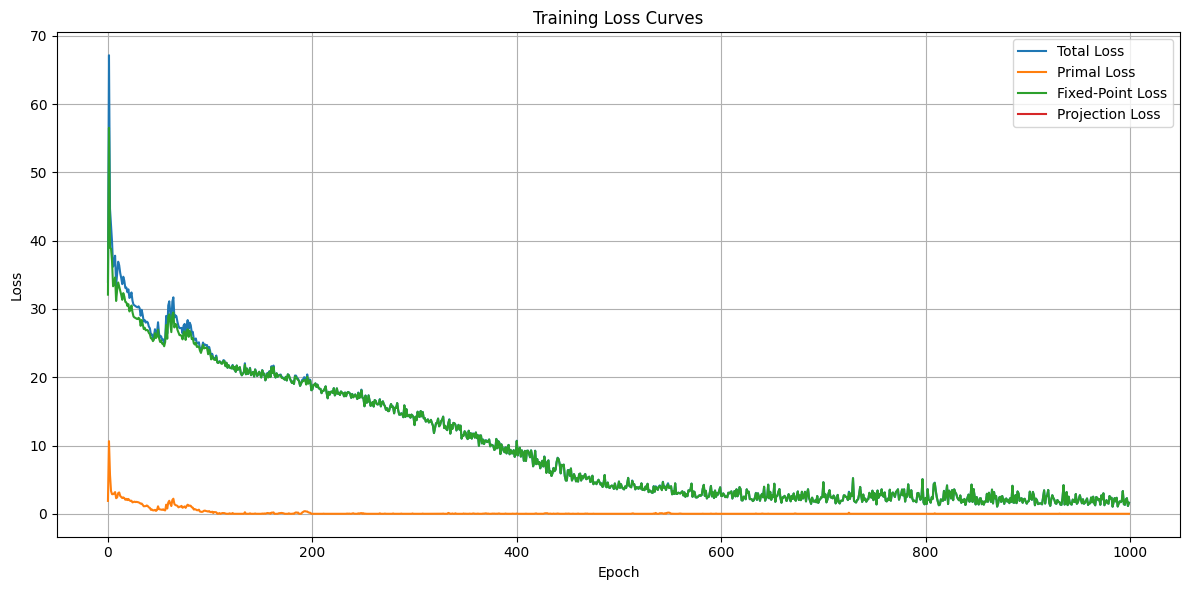

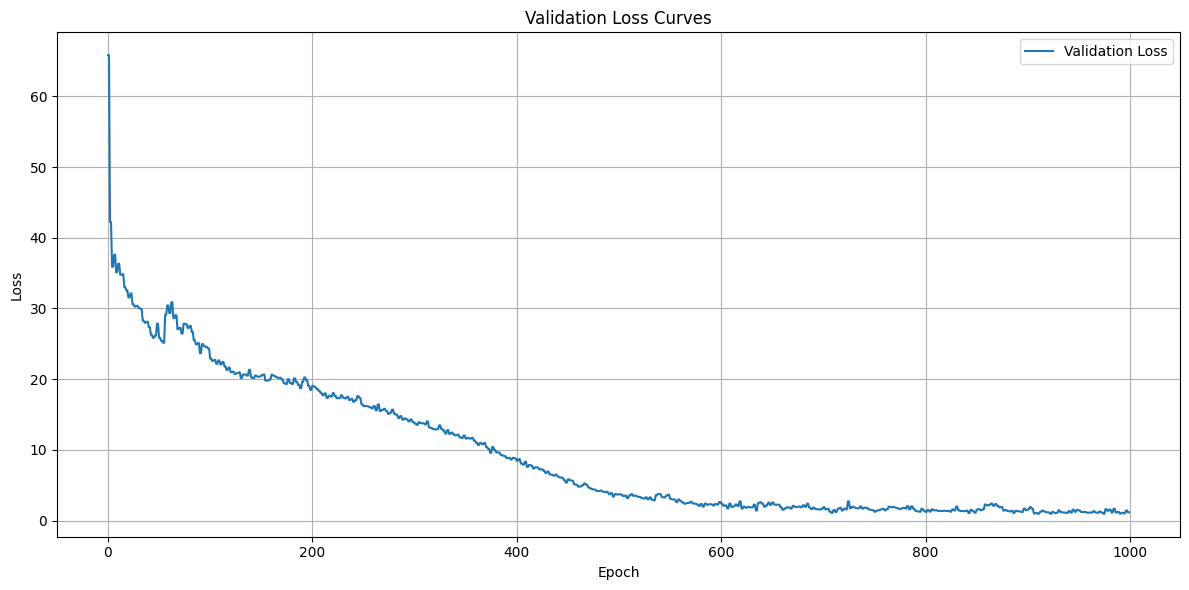

In [11]:
# Plot training losses

plt.figure(figsize=(12, 6))

plt.plot(avg_train_loss, label='Total Loss')
plt.plot(avg_primal_loss, label='Primal Loss')
plt.plot(avg_fixed_point_loss, label='Fixed-Point Loss')
plt.plot(avg_projection_loss, label='Projection Loss')


plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(avg_val_loss, label='Validation Loss')

plt.title('Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()